In [1]:
# Imports
from google.colab import drive
import os
import random
drive.mount('/content/drive')

!pip install torchinfo
from torchinfo import summary
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from tqdm import tqdm

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import defaultdict


# Dataset file pat
image_file_path = '/content/drive/My Drive/street_view_images'

Mounted at /content/drive


## Data Processing

In [6]:
select_cities = {
    "New Yorkd",
    "Los Angeles",
    "Wichita",
    "Houston",
    "Phoenix"
}

# 50 US cities into Koppen Climate Types
climate_map = {
    "continental_d": {
        "Wichita",
        "New Yorkd",
        "Omaha",
        "Milwaukee",
        "Minneapolis",
        "Kansas City",
        "Indianapolisg",
        "Columbus",
        "Detroit",
        "Chicago",
        "Boston"
    },
    "arid_b": {
        "Tucson",
        "Phoenix",
        "San Diego",
        "Mesa",
        "Las Vegas",
        "Colorado Springs",
        "Denveri",
        "El Paso",
        "Albuquerque"
    },
    "subtropical_cfa": {
        "Tampa",
        "Washingtonk",
        "Tulsa",
        "Virginia Beachm",
        "Raleigh",
        "San Antonio",
        "Oklahoma City",
        "Nashvillej",
        "Philadelphiae",
        "Memphis",
        "Jacksonvillef",
        "Louisvillel",
        "Houston",
        "Fort Worth",
        "Dallas",
        "Austin",
        "Atlanta",
        "Baltimorem",
        "Charlotte",
        "Miami"

    },
    "Mediterranean_csa": {
        "San Franciscoh",
        "San Jose",
        "Sacramento",
        "Oakland",
        "Long Beach",
        "Los Angeles",
        "Fresno",
        "Bakersfield"

    },
    "Marine_cfb": {
        "Seattle",
        "Portland"
    }
}

# 50 US cities into nine distinct geographic division defined by the U.S. Census Bureau
geographic_division_map = {
    "New England": {
        "Boston"
    },
    "Mid Atlantic": {
        "New Yorkd",
        "Philadelphiae"
    },
    "East North Central": {
        "Milwaukee",
        "Indianapolisg",
        "Columbus",
        "Detroit",
        "Chicago"
    },
    "West North Central": {
        "Wichita",
        "Omaha",
        "Minneapolis",
        "Kansas City"
    },
    "South Atlantic": {
        "Tampa",
        "Washingtonk",
        "Virginia Beachm",
        "Raleigh",
        "Miami",
        "Jacksonvillef",
        "Atlanta",
        "Baltimorem",
        "Charlotte"
    },
    "East South Central": {
        "Nashvillej",
        "Memphis",
        "Louisvillel"
    },
    "West South Centra": {
        "Tulsa",
        "San Antonio",
        "Oklahoma City",
        "Houston",
        "Fort Worth",
        "Dallas",
        "El Paso",
        "Austin"
    },
    "Mountain": {
        "Tucson",
        "Phoenix",
        "Mesa",
        "Las Vegas",
        "Colorado Springs",
        "Denveri",
        "Albuquerque"
    },
    "Pacific": {
        "San Franciscoh",
        "Seattle",
        "San Jose",
        "Portland",
        "Sacramento",
        "San Diego",
        "Oakland",
        "Long Beach",
        "Los Angeles",
        "Fresno",
        "Bakersfield"
    }
}

name_set = {"temp"}

# Print city names and count of cities
for file_name in os.listdir(image_file_path):
    image_path = os.path.join(image_file_path, file_name)
    city_name = file_name.split('_')[0]
    if city_name not in name_set:
        print(city_name)
        name_set.add(city_name)

name_set.remove("temp")
print(len(name_set))

San Franciscoh
San Jose
Seattle
Tampa
Washingtonk
Wichita
Tulsa
Tucson
Virginia Beachm
Portland
Raleigh
Phoenix
Sacramento
San Diego
San Antonio
Nashvillej
Oklahoma City
New Yorkd
Oakland
Omaha
Philadelphiae
Mesa
Miami
Memphis
Milwaukee
Minneapolis
Las Vegas
Jacksonvillef
Kansas City
Indianapolisg
Long Beach
Louisvillel
Los Angeles
El Paso
Denveri
Fort Worth
Detroit
Fresno
Houston
Dallas
Colorado Springs
Columbus
Bakersfield
Atlanta
Austin
Baltimorem
Chicago
Charlotte
Boston
Albuquerque
50


In [7]:
# Holds the images and labels without performing any transformations
class RawImages():
    def __init__(self, image_dir=None, data=None, labels=None):
        # Extract images and labels from directory
        if image_dir:
            data_t = []
            labels_t = []
            for file_name in os.listdir(image_dir):
                if file_name.endswith(('.jpg')):
                    image_path = os.path.join(image_dir, file_name)
                    label = file_name.split('_')[0]
                    image = Image.open(image_path).convert('RGB')
                    data_t.append(image)
                    labels_t.append(label)

            self.data = data_t
            self.labels = labels_t
        else:
            self.data = data
            self.labels = labels


    # Returns new RawImages instance, where only data with labels in map are retained
    def filter_images(self, map: dict):
        data = []
        labels = []
        i = 0
        for label in self.labels:
            if label in map:
                data.append(self.data[i])
                labels.append(label)
            i += 1
        return self.__class__(data=data, labels=labels)

    # Returns new RawImages instance, where the labels are changed to the value of the map
    def new_labels(self, map: dict):
        data = []
        labels = []
        i = 0
        for label in self.labels:
            data.append(self.data[i])
            labels.append(map[label])
            i += 1
        return self.__class__(data=data, labels=labels)

# converts dictionary of key: set(items) into a dictionary of items: key
def make_key(map: dict):
    res = {}
    for key, value in map.items():
        for item in value:
            res.update({item: key})
    return res

# Class for importing the dataset, performs image transformations, converts labels to ints, converts data,labels to numpy arrays
class ImageDataset(Dataset):
    def __init__(self, transform, rawImages: RawImages):
        self.transform = transform

        self.data = np.stack([np.array(self.transform(image)) for image in rawImages.data])
        self.labels = np.array(rawImages.labels)

        # Map city names to integer labels using numpy
        unique_labels, encoded_labels = np.unique(self.labels, return_inverse=True)
        self.label_mapping = {city: idx for idx, city in enumerate(unique_labels)}
        self.encoded_labels = encoded_labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Directly return preloaded image and label
        image = self.data[idx]
        label = self.encoded_labels[idx]
        return image, label

## CNN Model Models

------


### Naive Models

In [8]:
# CNN with only 1 conv layer
class SuperTinyCNN(nn.Module):
    def __init__(self, num_classes, img_size=32, in_channels=3, num_filters=32, num_kernels=3, dropout_rate=0.5, pooling=False, batch_norm=False):
        super(SuperTinyCNN, self).__init__()

        self.use_pooling = pooling
        self.use_batchnorm = batch_norm

        self.conv1 = nn.Conv2d(in_channels, num_filters, kernel_size=num_kernels, padding=1)
        self.dropout = nn.Dropout(dropout_rate)

        if self.use_batchnorm:
            self.batch_norm = nn.BatchNorm2d(num_filters)

        pool_size = img_size // 2 if self.use_pooling else img_size
        self.fc = nn.Linear(num_filters * pool_size * pool_size, num_classes)

    def forward(self, x):

        x = self.conv1(x)
        if self.use_batchnorm:
            x = self.batch_norm(x)

        x = F.relu(x)

        if self.use_pooling:
            x = F.max_pool2d(x, 2)

        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# 3 layered CNN
class LayeredCNN(nn.Module):

    def __init__(self, num_classes, img_size=32, in_channels=3, num_filters=32,
                 num_kernels=3, dropout_rate=0.5, pooling=False, batch_norm=False):
        super(LayeredCNN, self).__init__()

        self.use_pooling = pooling
        self.use_batchnorm = batch_norm

        # Add conv three layers
        self.conv1 = nn.Conv2d(in_channels, num_filters, kernel_size=num_kernels, padding=1)
        if self.use_batchnorm:
            self.batch_norm1 = nn.BatchNorm2d(num_filters)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.conv2 = nn.Conv2d(num_filters, num_filters * 2, kernel_size=num_kernels, padding=1)
        if self.use_batchnorm:
            self.batch_norm2 = nn.BatchNorm2d(num_filters * 2)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.conv3 = nn.Conv2d(num_filters * 2, num_filters * 4, kernel_size=num_kernels, padding=1)
        if self.use_batchnorm:
            self.batch_norm3 = nn.BatchNorm2d(num_filters * 4)
        self.dropout3 = nn.Dropout(dropout_rate)

        # Pooling layers, for after 1st and last conv layer
        self.first_pool = nn.MaxPool2d(2, 2) if pooling else None
        self.last_pool = nn.MaxPool2d(2, 2) if pooling else None

        pool_size = img_size // 4 if self.use_pooling else img_size
        self.fc1 = nn.Linear(4 * num_filters * pool_size * pool_size, num_classes)

    def forward(self, x):

        # Layer 1
        x = self.conv1(x)
        if self.use_batchnorm:
            x = self.batch_norm1(x)
        x = F.relu(x)

        if self.use_pooling: # first pool
            x = self.first_pool(x)

        x = self.dropout1(x)

        # Layer 2
        x = self.conv2(x)
        if self.use_batchnorm:
            x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        # Layer 3
        x = self.conv3(x)
        if self.use_batchnorm:
            x = self.batch_norm3(x)
        x = F.relu(x)
        if self.use_pooling: # last pool
            x = self.last_pool(x)

        x = self.dropout3(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

### Pretrained CNN: ResNet

In [9]:
def create_resnet_model(num_classes, freeze_backbone=True):
    # Load a pretrained ResNet
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT, progress=True)
    if freeze_backbone:
        for param in model.parameters():
            param.requires_grad = False
        for param in model.fc.parameters():
            param.requires_grad = True

    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

In [10]:
# Tranformers
def var_size_transformer(size):
    return transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

resNetTransformer = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet standard 224x224 input size
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard for ResNet
])

Data Info:
Raw Data size:  8370 ,  8370
Specific City Data size:  907 ,  907
Geo size:  8370 ,  8370
Climate size:  8370 ,  8370


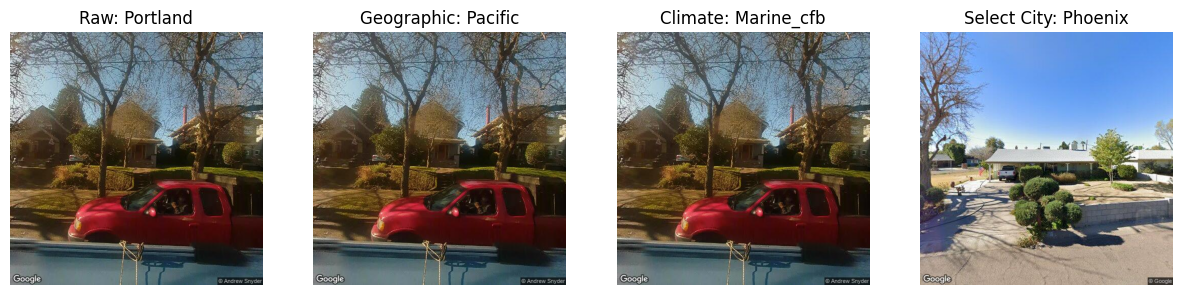

In [11]:
# Import data

# Holds jpg images and labels
raw_data = RawImages(image_file_path)

raw_specific_cities_data = raw_data.filter_images(select_cities) # only cities in top_us_cities

geo_div_key = make_key(geographic_division_map)
raw_geo_div_data = raw_data.new_labels(geo_div_key) # cities labeled by geographical division

climate_key = make_key(climate_map)
raw_climate_data = raw_data.new_labels(climate_key) # cities labeled by climate type


# Print data info
print("Data Info:")
print("Raw Data size: " , len(raw_data.data), ", " , len(raw_data.labels))
print("Specific City Data size: " , len(raw_specific_cities_data.data), ", " , len(raw_specific_cities_data.labels))
print("Geo size: " , len(raw_geo_div_data.data), ", " , len(raw_geo_div_data.labels))
print("Climate size: " , len(raw_climate_data.data), ", " , len(raw_climate_data.labels))


# Print random image
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

random_index = random.randint(0, len(raw_data.data) - 1)

random_image = raw_data.data[random_index]
random_label = raw_data.labels[random_index]
axes[0].imshow(random_image)
axes[0].set_title(f"Raw: {random_label}")
axes[0].axis('off')

random_image = raw_geo_div_data.data[random_index]
random_label = raw_geo_div_data.labels[random_index]
axes[1].imshow(random_image)
axes[1].set_title(f"Geographic: {random_label}")
axes[1].axis('off')


random_image = raw_climate_data.data[random_index]
random_label = raw_climate_data.labels[random_index]
axes[2].imshow(random_image)
axes[2].set_title(f"Climate: {random_label}")
axes[2].axis('off')

random_index = random.randint(0, len(raw_specific_cities_data.data) - 1)
random_image = raw_specific_cities_data.data[random_index]
random_label = raw_specific_cities_data.labels[random_index]
axes[3].imshow(random_image)
axes[3].set_title(f"Select City: {random_label}")
axes[3].axis('off')

plt.show()


In [12]:
# Create Dataset

# Select Cities
resnet_dataset_select_cities = ImageDataset(resNetTransformer, raw_specific_cities_data)
dataset_select_cities_32 = ImageDataset(var_size_transformer(32), raw_specific_cities_data)
dataset_select_cities_64 = ImageDataset(var_size_transformer(64), raw_specific_cities_data)
#dataset_select_cities_16 = ImageDataset(var_size_transformer(16), raw_specific_cities_data)

# Climate Types
resnet_dataset_climate = ImageDataset(resNetTransformer, raw_climate_data)
dataset_climate_32 = ImageDataset(var_size_transformer(32), raw_climate_data)
dataset_climate_64 = ImageDataset(var_size_transformer(64), raw_climate_data)
#dataset_climate_16 = ImageDataset(var_size_transformer(16), raw_climate_data)


# # Geographic Divisions
# dataset_geo_16 = ImageDataset(var_size_transformer(16), raw_geo_div_data)
# dataset_geo_32 = ImageDataset(var_size_transformer(32), raw_geo_div_data)
# resnet_dataset_geo = ImageDataset(resNetTransformer, raw_geo_div_data)

In [13]:
# For the confusion matrix labels
city_label_mapping: dict = dataset_select_cities_64.label_mapping
print(city_label_mapping)
reverse_label_mapping = {v: k for k, v in city_label_mapping.items()}
print(reverse_label_mapping)

city_label_mapping: dict = dataset_climate_64.label_mapping
print(city_label_mapping)
reverse_climate_label_mapping = {v: k for k, v in city_label_mapping.items()}
print(reverse_climate_label_mapping)

{'Houston': 0, 'Los Angeles': 1, 'New Yorkd': 2, 'Phoenix': 3, 'Wichita': 4}
{0: 'Houston', 1: 'Los Angeles', 2: 'New Yorkd', 3: 'Phoenix', 4: 'Wichita'}
{'Marine_cfb': 0, 'Mediterranean_csa': 1, 'arid_b': 2, 'continental_d': 3, 'subtropical_cfa': 4}
{0: 'Marine_cfb', 1: 'Mediterranean_csa', 2: 'arid_b', 3: 'continental_d', 4: 'subtropical_cfa'}


In [15]:
print("resnet_dataset_select_cities: ", resnet_dataset_select_cities.data.shape)
print("dataset_select_cities_32: ", dataset_select_cities_32.data.shape)
#print("dataset_select_cities_16: ", dataset_select_cities_16.data.shape)


print("resnet_dataset_climate: ", resnet_dataset_climate.data.shape)
print("dataset_climate_32: ", dataset_climate_32.data.shape)
#print("dataset_climate_16: ", dataset_climate_16.data.shape)

# print("resnet_dataset_geo: ", resnet_dataset_geo.data.shape)
# print("dataset_geo_16: ", dataset_geo_16.data.shape)
# print("dataset_geo_32: ", dataset_geo_32.data.shape)

resnet_dataset_select_cities:  (907, 3, 224, 224)
dataset_select_cities_32:  (907, 3, 32, 32)
resnet_dataset_climate:  (8370, 3, 224, 224)
dataset_climate_32:  (8370, 3, 32, 32)


In [16]:
# verify a gpu is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [17]:
def train_epoch(model, train_loader, optimizer, criterion, device):

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track metrics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc


def validate_epoch(model, valid_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track metrics
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(valid_loader)
    val_acc = 100.0 * correct / total
    return val_loss, val_acc

def eval_model(model, test_loader, device):
    model.eval()
    for batch in test_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        logits = model(x)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).sum() / x.size(0)
        print(f'Test Acc {acc}')
        return acc

def train_model(model, train_loader, valid_loader, test_loader, optimizer, criterion, epochs, device):

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    learning_rates = []

    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    for epoch in range(epochs):
        #print(f"\nEpoch {epoch + 1}/{epochs}")

        # Train the model
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        # print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validate the model
        val_loss, val_acc = validate_epoch(model, valid_loader, criterion, device)
        # print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)

    acc = eval_model(model, test_loader, device)

    # Return the collected metrics
    return {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "test_acc": acc,
        "learning_rates": learning_rates,
    }

In [18]:
import itertools

def grid_search(data_tr, data_va, data_te, device, img_size, epochs, learning_rates=[1e-2, 1e-3, 1e-4], batch_sizes=[16, 64], weight_decays=[1e-3, 1e-4, 1e-5, 0], dropout_rates=[0, 0.5], batch_norm=[True], pooling=[False], num_classes=5):
    # Define hyperparameter search space
    learning_rates = learning_rates
    batch_sizes = batch_sizes
    dropout_rates = dropout_rates
    weight_decays = weight_decays
    batch_norm = batch_norm
    pooling = pooling

    # Store results
    best_test = 0.0
    results = {}

    # Generate all parameter combinations
    param_combinations = list(itertools.product(
        learning_rates, batch_sizes, dropout_rates, weight_decays, batch_norm, pooling
    ))

    print(f"Total combinations to evaluate: {len(param_combinations)}")

    for params in param_combinations:
        lr, batch_size, dropout, weight_decay, use_batch_norm, use_pooling = params

        print(f"\nEvaluating combination: "
              f"LR={lr}, Batch Size={batch_size}, Dropout={dropout}, "
              f"Weight Decay={weight_decay}, Batch Norm={use_batch_norm}, Pooling={use_pooling}")

        # Initialize model with current parameters
        # model = SuperTinyCNN(num_classes=5, img_size=16, num_filters=16, dropout_rate=dropout).to(device)
        if img_size == 64 or img_size == 32:
            model = LayeredCNN(num_classes=5, img_size=img_size, num_filters=img_size, dropout_rate=dropout, batch_norm=use_batch_norm, pooling=use_pooling).to(device)
        else:
            model = create_resnet_model(num_classes=5, freeze_backbone=use_batch_norm).to(device)

        # Adjust the optimizer
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        # Define criterion
        criterion = nn.CrossEntropyLoss(reduction='mean')

        # Adjust the data loader for batch size
        train_loader = torch.utils.data.DataLoader(data_tr, batch_size=batch_size, shuffle=True, num_workers=4)
        valid_loader = torch.utils.data.DataLoader(data_va, batch_size=len(data_va), shuffle=False, num_workers=4)
        test_loader = torch.utils.data.DataLoader(data_te, batch_size=len(data_te), shuffle=False, num_workers=4)

        # Train the model with the current parameters
        metrics = train_model(model, train_loader, valid_loader, test_loader, optimizer, criterion, epochs, device)

        if metrics['val_accuracies'][epochs-1] > best_test:
            best_test = metrics['val_accuracies'][epochs-1]
            results = {
                "params": {
                    "learning_rate": lr,
                    "batch_size": batch_size,
                    "dropout_rate": dropout,
                    "weight_decay": weight_decay,
                    "batch_norm": use_batch_norm,
                    "pooling": use_pooling,
                },
                "metrics": metrics,
                "model": model,
                "test_loader": test_loader,
                "optimizer": optimizer
            }

    return results

In [19]:
print(city_label_mapping)
def get_charts(res, climate=False):

    # print(f"Best Parameters: {best_params}")
    # print(f"Best Test Accuracy: {best_metrics['test_acc']}")

    # Extract losses
    train_losses = res["metrics"]["train_accuracies"]
    val_losses = res["metrics"]["val_accuracies"]

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Accuracy", marker='o')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Accuracy", marker='s')
    plt.title("Training and Validation Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    model = res["model"]  # Best model from the results
    test_loader = res["test_loader"]  # Test loader from the results

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    if climate:

        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[reverse_climate_label_mapping[i] for i in range(len((reverse_climate_label_mapping)))])
    else:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[reverse_label_mapping[i] for i in range(len(reverse_label_mapping))])
    disp.plot(cmap="Blues")  # Optionally set a colormap for better visualization
    plt.title("Confusion Matrix")
    plt.show()


{'Marine_cfb': 0, 'Mediterranean_csa': 1, 'arid_b': 2, 'continental_d': 3, 'subtropical_cfa': 4}


In [20]:
# Create train, test and validate DataLoaders, using 60% - 20% - 20%

# geo_data_tr_32, geo_data_va_32, geo_data_te_32 = torch.utils.data.random_split(dataset_geo_32, [0.7, 0.15, 0.15])
# geo_data_tr_resnet, geo_data_va_resnet, geo_data_te_resnet = torch.utils.data.random_split(resnet_dataset_geo, [0.7, 0.15, 0.15])
# #geo_data_tr_16, geo_data_va_16, geo_data_te_16 = torch.utils.data.random_split(dataset_geo_16, [0.7, 0.15, 0.15])

data_tr_resnet, data_va_resnet, data_te_resnet = torch.utils.data.random_split(resnet_dataset_select_cities, [0.6, 0.2, 0.2])
data_tr_32, data_va_32, data_te_32 = torch.utils.data.random_split(dataset_select_cities_32, [0.6, 0.2, 0.2])
data_tr_64, data_va_64, data_te_64 = torch.utils.data.random_split(dataset_select_cities_64, [0.6, 0.2, 0.2])

#climate_data_tr_16, climate_data_va_16, climate_data_te_16 = torch.utils.data.random_split(dataset_climate_16, [0.7, 0.15, 0.15])

climate_data_tr_32, climate_data_va_32, climate_data_te_32 = torch.utils.data.random_split(dataset_climate_32, [0.6, 0.2, 0.2])
climate_data_tr_resnet, climate_data_va_resnet, climate_data_te_resnet = torch.utils.data.random_split(resnet_dataset_climate, [0.6, 0.2, 0.2])

# Current size of the dataset
current_size = len(climate_data_tr_resnet)

# Calculate the new size (1/4 of the current size)
new_size = current_size // 8

# Select the first `new_size` indices
from torch.utils.data import Subset

subset_indices = list(range(new_size))
climate_data_tr_resnet_reduced = Subset(climate_data_tr_resnet, subset_indices)


current_size = len(climate_data_va_resnet)

# Calculate the new size (1/4 of the current size)
new_size = current_size // 8

subset_indices = list(range(new_size))
climate_data_va_resnet_reduced = Subset(climate_data_va_resnet, subset_indices)

current_size = len(climate_data_te_resnet)

# Calculate the new size (1/4 of the current size)
new_size = current_size // 8


subset_indices = list(range(new_size))
climate_data_te_resnet_reduced = Subset(climate_data_te_resnet, subset_indices)

In [ ]:
# City 64x64
# Coarse grid search
data_tr_64, data_va_64, data_te_64 = torch.utils.data.random_split(dataset_select_cities_64, [0.6, 0.2, 0.2])
res = grid_search(data_tr=data_tr_64, data_va=data_va_64, data_te=data_te_64, device=device, img_size=64, epochs=3)
print(res)
get_charts(res)
# best 0.5525

Total combinations to evaluate: 48

Evaluating combination: LR=0.001, Batch Size=16, Dropout=0, Weight Decay=0.001, Batch Norm=True, Pooling=False
Test Acc 0.45303869247436523

Evaluating combination: LR=0.001, Batch Size=16, Dropout=0, Weight Decay=0.0001, Batch Norm=True, Pooling=False
Test Acc 0.4033149182796478

Evaluating combination: LR=0.001, Batch Size=16, Dropout=0, Weight Decay=1e-05, Batch Norm=True, Pooling=False
Test Acc 0.4419889748096466

Evaluating combination: LR=0.001, Batch Size=16, Dropout=0, Weight Decay=0, Batch Norm=True, Pooling=False
Test Acc 0.46961328387260437

Evaluating combination: LR=0.001, Batch Size=16, Dropout=0.3, Weight Decay=0.001, Batch Norm=True, Pooling=False
Test Acc 0.2928176820278168

Evaluating combination: LR=0.001, Batch Size=16, Dropout=0.3, Weight Decay=0.0001, Batch Norm=True, Pooling=False
Test Acc 0.4033149182796478

Evaluating combination: LR=0.001, Batch Size=16, Dropout=0.3, Weight Decay=1e-05, Batch Norm=True, Pooling=False
Test Ac

KeyError: 'metrics'

Total combinations to evaluate: 1

Evaluating combination: LR=1e-05, Batch Size=32, Dropout=0, Weight Decay=0.0001, Batch Norm=True, Pooling=False
Test Acc 0.5359116196632385


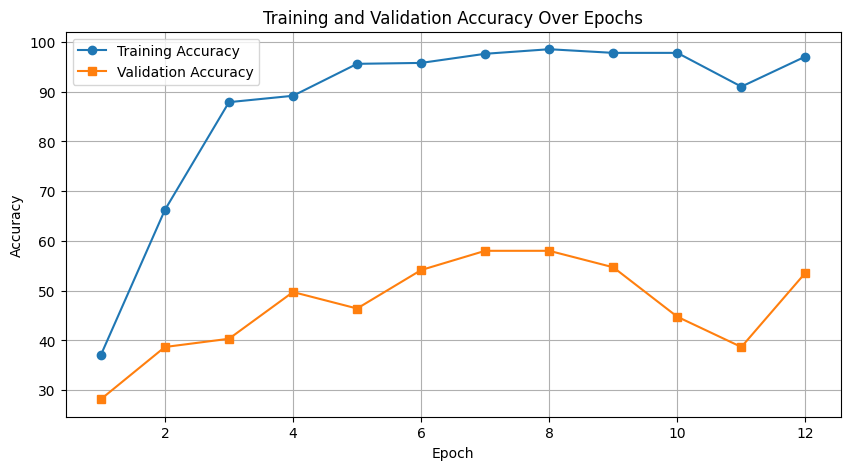

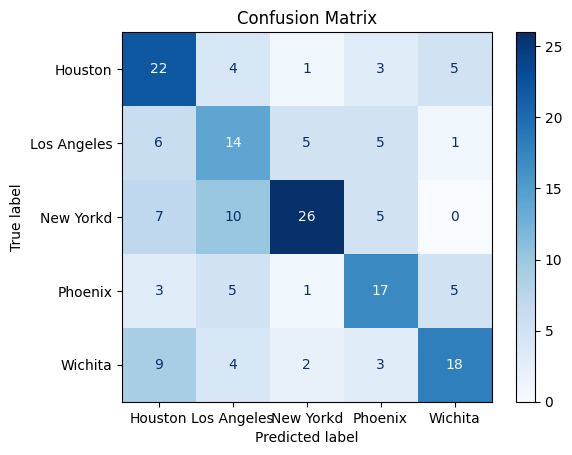

In [ ]:
# City 64x64
# Fine Grid Search
best_params = res["params"]
best_lr = best_params["learning_rate"]
best_decay = best_params["weight_decay"]
best_batch = best_params["batch_size"]
best_dropout = best_params["dropout_rate"]

lr_range = [best_lr, best_lr*10, best_lr/10]
batch_range = [best_batch, best_batch*2, best_batch // 2]
weight_decay_range = [best_decay, best_decay*10, best_decay/10]
dropout_range = [best_dropout]

res = grid_search(data_tr=data_tr_64, data_va=data_va_64, data_te=data_te_64, device=device, img_size=64, epochs=12,
                  learning_rates=lr_range, batch_sizes=batch_range, weight_decays=weight_decay_range, dropout_rates=dropout_range)
print(res)
get_charts(res)

Total combinations to evaluate: 32

Evaluating combination: LR=0.001, Batch Size=16, Dropout=0, Weight Decay=0.001, Batch Norm=True, Pooling=False
Test Acc 0.6022099852561951

Evaluating combination: LR=0.001, Batch Size=16, Dropout=0, Weight Decay=0.001, Batch Norm=False, Pooling=False
Test Acc 0.46961328387260437

Evaluating combination: LR=0.001, Batch Size=16, Dropout=0, Weight Decay=0.0001, Batch Norm=True, Pooling=False
Test Acc 0.5580110549926758

Evaluating combination: LR=0.001, Batch Size=16, Dropout=0, Weight Decay=0.0001, Batch Norm=False, Pooling=False
Test Acc 0.2983425557613373

Evaluating combination: LR=0.001, Batch Size=16, Dropout=0, Weight Decay=1e-05, Batch Norm=True, Pooling=False
Test Acc 0.5359116196632385

Evaluating combination: LR=0.001, Batch Size=16, Dropout=0, Weight Decay=1e-05, Batch Norm=False, Pooling=False
Test Acc 0.5469613671302795

Evaluating combination: LR=0.001, Batch Size=16, Dropout=0, Weight Decay=0, Batch Norm=True, Pooling=False
Test Acc 0.

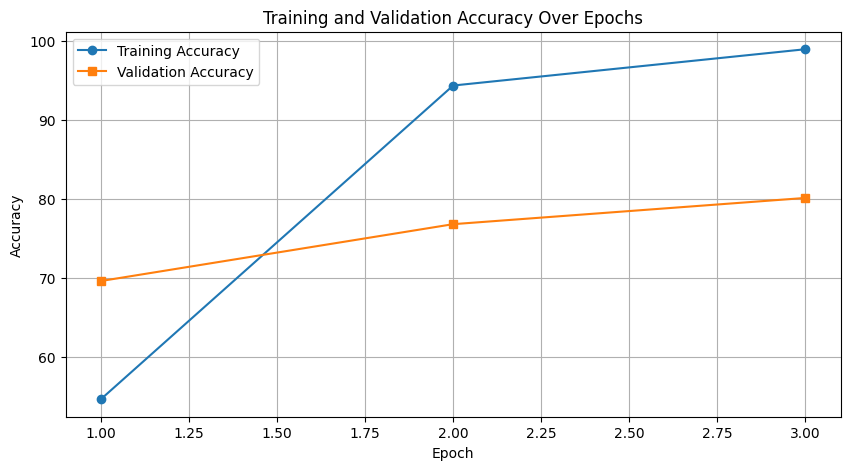

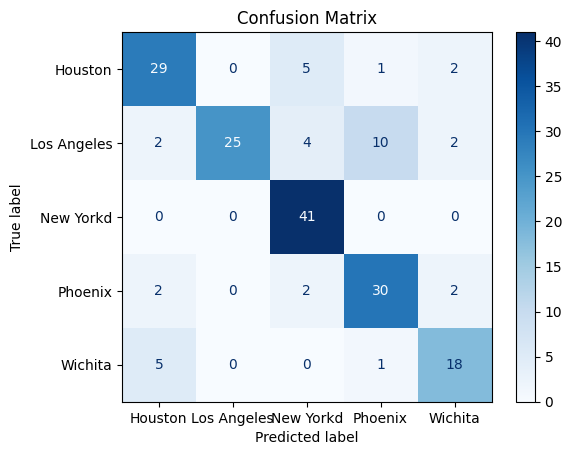

In [ ]:
# City 224x224 (ResNet)
# Coarse grid search
data_tr_224, data_va_224, data_te_224 = torch.utils.data.random_split(resnet_dataset_select_cities, [0.6, 0.2, 0.2])
res_224 = grid_search(data_tr=data_tr_224, data_va=data_va_224, data_te=data_te_224, device=device, img_size=224, epochs=3, batch_norm=[True, False], dropout_rates=[0])
print(res_224)
get_charts(res_224)
# best ???

In [ ]:
# City 224x224 (ResNet)
# Fine grid search
best_params = res_224["params"]
best_lr = best_params["learning_rate"]
best_decay = best_params["weight_decay"]
best_batch = best_params["batch_size"]
best_dropout = best_params["dropout_rate"]
batch_norm = best_params["batch_norm"]

lr_range = [best_lr, best_lr*10, best_lr/10]
batch_range = [best_batch, best_batch*2, best_batch // 2]
weight_decay_range = [best_decay, best_decay*10, best_decay/10]
dropout_range = [best_dropout]
batch_norm_range = [batch_norm]

res_224 = grid_search(data_tr=data_tr_64, data_va=data_va_64, data_te=data_te_64, device=device, img_size=224, epochs=12,
                  learning_rates=lr_range, batch_sizes=batch_range, weight_decays=weight_decay_range, dropout_rates=dropout_range, batch_norm=batch_norm_range)
print(res_224)
get_charts(res_224)

Total combinations to evaluate: 27

Evaluating combination: LR=0.0001, Batch Size=16, Dropout=0.3, Weight Decay=1e-05, Batch Norm=False, Pooling=False
Test Acc 0.5469613671302795

Evaluating combination: LR=0.0001, Batch Size=16, Dropout=0.3, Weight Decay=0.0001, Batch Norm=False, Pooling=False
Test Acc 0.6022099852561951

Evaluating combination: LR=0.0001, Batch Size=16, Dropout=0.3, Weight Decay=1.0000000000000002e-06, Batch Norm=False, Pooling=False
Test Acc 0.4917127192020416

Evaluating combination: LR=0.0001, Batch Size=32, Dropout=0.3, Weight Decay=1e-05, Batch Norm=False, Pooling=False
Test Acc 0.4917127192020416

Evaluating combination: LR=0.0001, Batch Size=32, Dropout=0.3, Weight Decay=0.0001, Batch Norm=False, Pooling=False
Test Acc 0.4861878752708435

Evaluating combination: LR=0.0001, Batch Size=32, Dropout=0.3, Weight Decay=1.0000000000000002e-06, Batch Norm=False, Pooling=False
Test Acc 0.5248618721961975

Evaluating combination: LR=0.0001, Batch Size=8, Dropout=0.3, We

KeyboardInterrupt: 

Total combinations to evaluate: 48

Evaluating combination: LR=0.01, Batch Size=16, Dropout=0, Weight Decay=0.001, Batch Norm=True, Pooling=False
Test Acc 0.430939257144928

Evaluating combination: LR=0.01, Batch Size=16, Dropout=0, Weight Decay=0.0001, Batch Norm=True, Pooling=False
Test Acc 0.33701658248901367

Evaluating combination: LR=0.01, Batch Size=16, Dropout=0, Weight Decay=1e-05, Batch Norm=True, Pooling=False
Test Acc 0.3867403566837311

Evaluating combination: LR=0.01, Batch Size=16, Dropout=0, Weight Decay=0, Batch Norm=True, Pooling=False
Test Acc 0.3425414562225342

Evaluating combination: LR=0.01, Batch Size=16, Dropout=0.5, Weight Decay=0.001, Batch Norm=True, Pooling=False
Test Acc 0.430939257144928

Evaluating combination: LR=0.01, Batch Size=16, Dropout=0.5, Weight Decay=0.0001, Batch Norm=True, Pooling=False
Test Acc 0.37569060921669006

Evaluating combination: LR=0.01, Batch Size=16, Dropout=0.5, Weight Decay=1e-05, Batch Norm=True, Pooling=False
Test Acc 0.29281

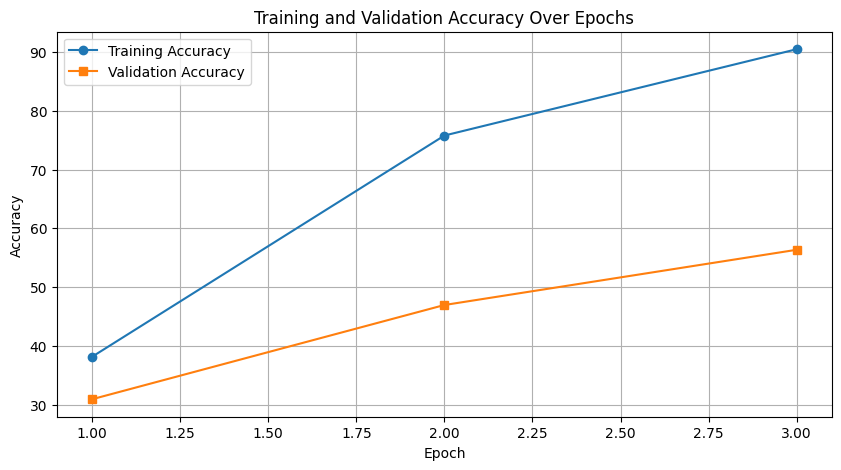

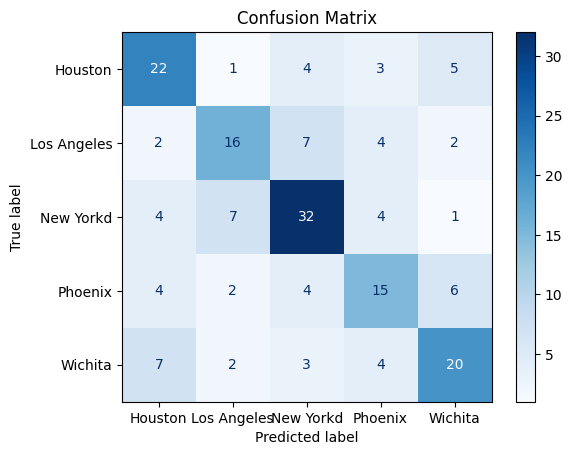

In [ ]:
# Climate 64x64
# Coarse grid search
climate_tr_64, climate_va_64, climate_te_64 = torch.utils.data.random_split(dataset_climate_64, [0.6, 0.2, 0.2])
res = grid_search(data_tr=data_tr_64, data_va=data_va_64, data_te=data_te_64, device=device, img_size=64, epochs=3)
print(res)
get_charts(res)
# best

San Franciscoh: 194
San Jose: 195
Seattle: 176
Tampa: 194
Washingtonk: 82
Wichita: 157
Tulsa: 170
Tucson: 62
Virginia Beachm: 8
Portland: 194
Raleigh: 196
Phoenix: 180
Sacramento: 179
San Diego: 131
San Antonio: 199
Nashvillej: 185
Oklahoma City: 173
New Yorkd: 190
Oakland: 152
Omaha: 193
Philadelphiae: 196
Mesa: 145
Miami: 194
Memphis: 187
Milwaukee: 191
Minneapolis: 196
Las Vegas: 195
Jacksonvillef: 178
Kansas City: 177
Indianapolisg: 198
Long Beach: 168
Louisvillel: 153
Los Angeles: 189
El Paso: 105
Denveri: 185
Fort Worth: 138
Detroit: 183
Fresno: 158
Houston: 191
Dallas: 189
Colorado Springs: 168
Columbus: 190
Bakersfield: 184
Atlanta: 184
Austin: 185
Baltimorem: 102
Chicago: 190
Charlotte: 191
Boston: 71
Albuquerque: 179


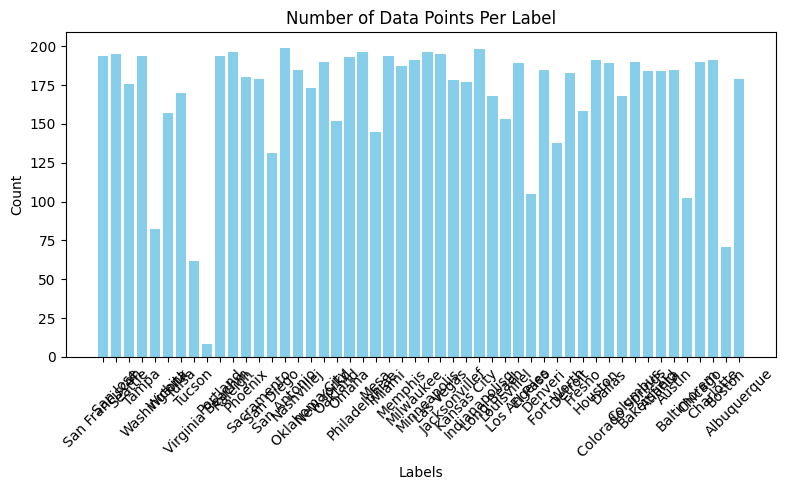

In [26]:
from collections import Counter

def show_label_distribution(dataset):
    label_counts = Counter(dataset.labels)

    for label, count in label_counts.items():
        print(f"{label}: {count}")

    # Plot the label distribution
    labels = list(label_counts.keys())
    counts = list(label_counts.values())

    plt.figure(figsize=(8, 5))
    plt.bar(labels, counts, color='skyblue')
    plt.title("Number of Data Points Per Label")
    plt.xlabel("Labels")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

show_label_distribution(raw_data)


#### 64x64 Layered CNN ResNet Cities

- Coarse and fine grid search
- Best params:
    - learning_rate: 1e-05
    - batch_size: 32
    - dropout_rate: 0
    - weight_decay: 0.0001


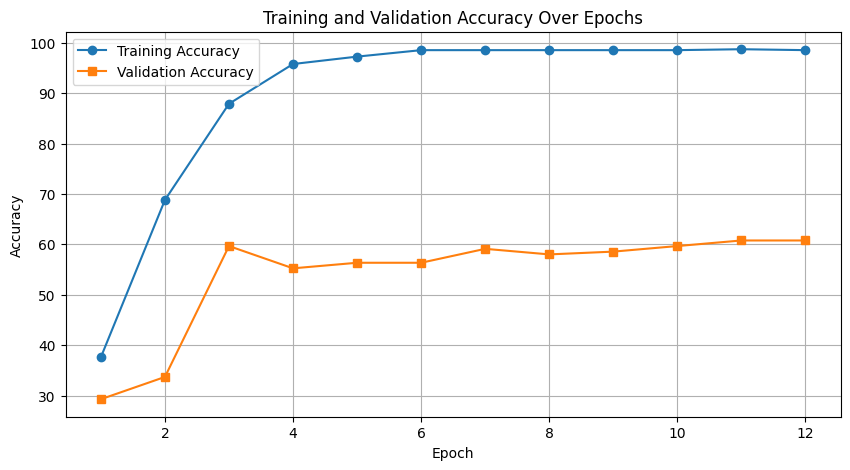

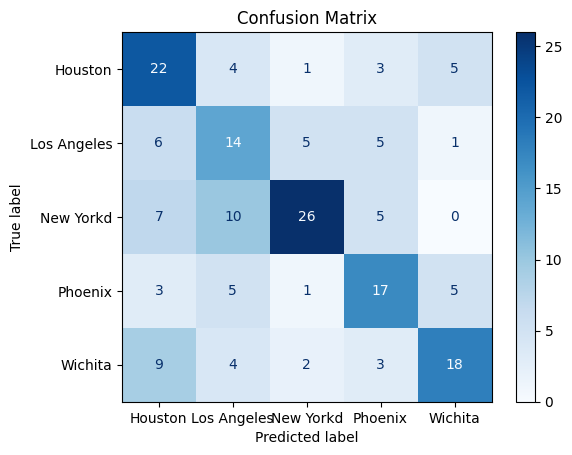

#### 224x224 ResNet Cities


Evaluating combination: LR=0.001, Batch Size=64, Dropout=0, Weight Decay=0.0001, Batch Norm=False, Pooling=False
Test Acc 0.6850829124450684


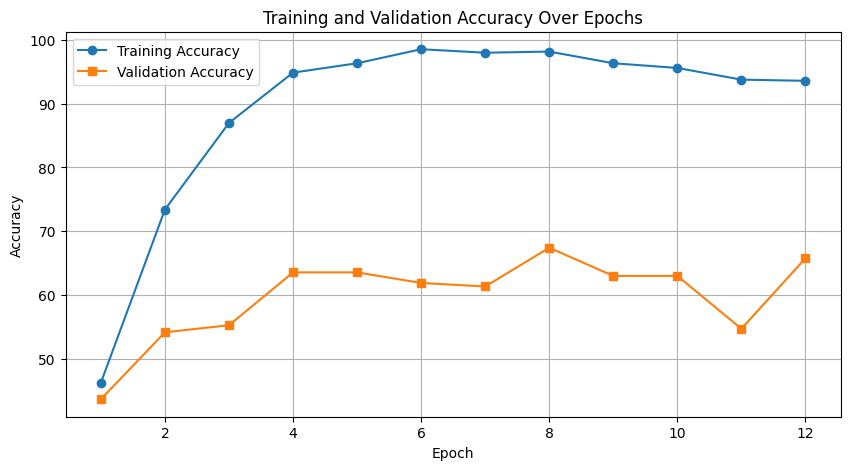

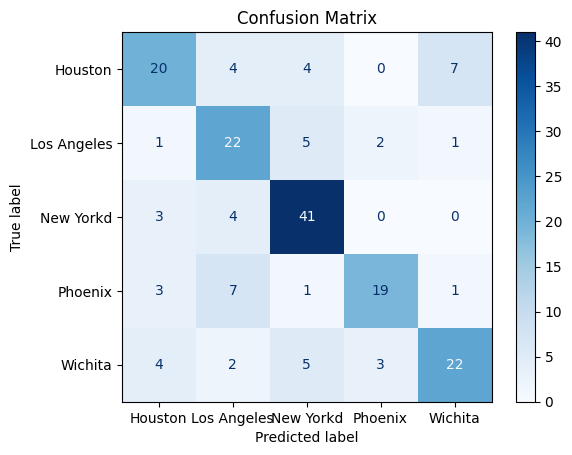